# Fitting the Random Forest

In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
wine = pd.read_csv('../Ch07-SHAP for Linear Models/wine.csv')
y = wine['quality']
X = wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42 )
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [4]:
from sklearn.metrics import mean_absolute_error
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE:', round(mae, 2))

MAE: 0.42


# Computing SHAP Values

In [5]:
import shap 
# Compute the SHAP values for the sample 
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 98%|===================| 959/980 [00:35<00:00]        

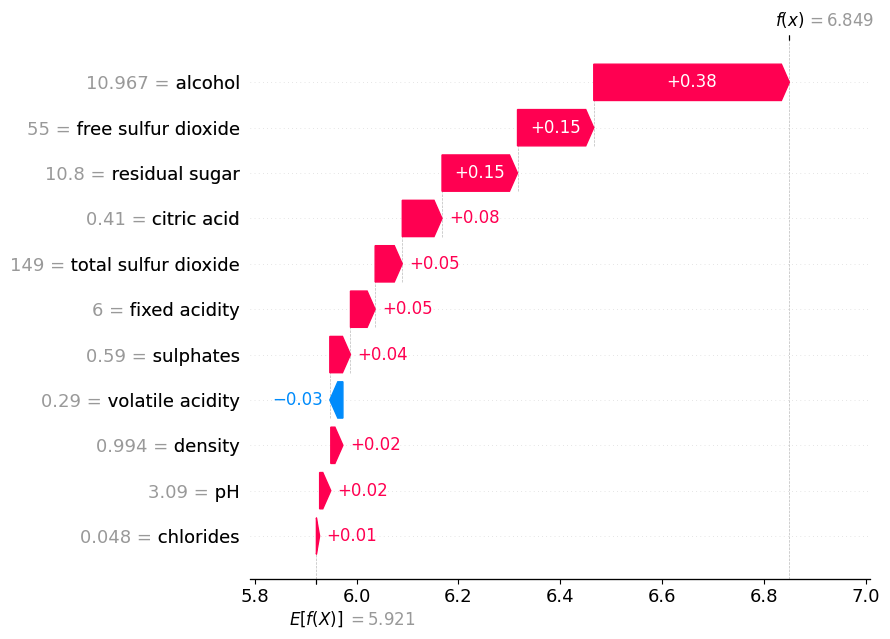

In [6]:
shap.plots.waterfall(shap_values[0], max_display=11)

# Global model interpretation

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


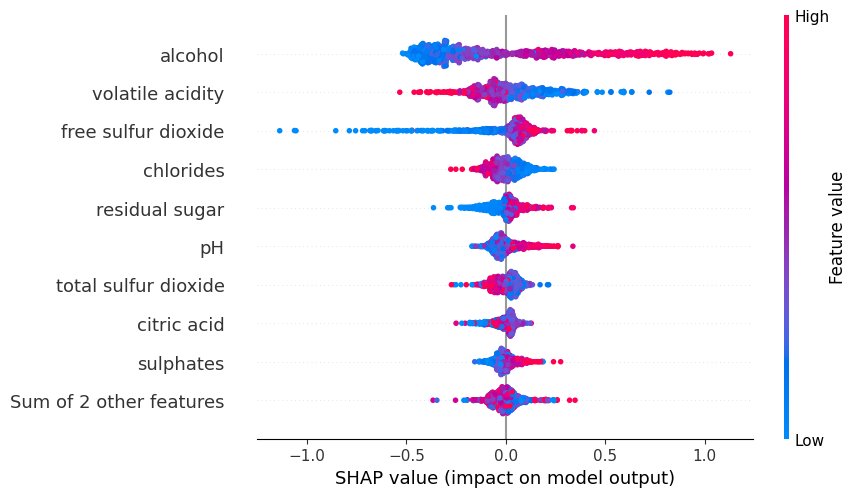

In [7]:
shap.plots.beeswarm(shap_values)

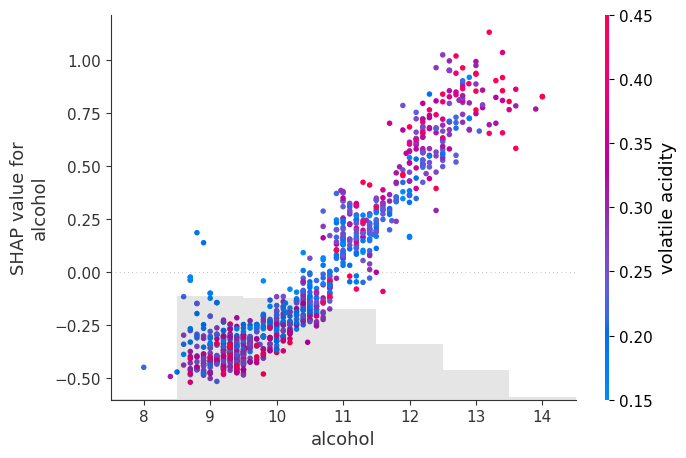

In [8]:
shap.plots.scatter(shap_values[:,"alcohol"], color=shap_values)

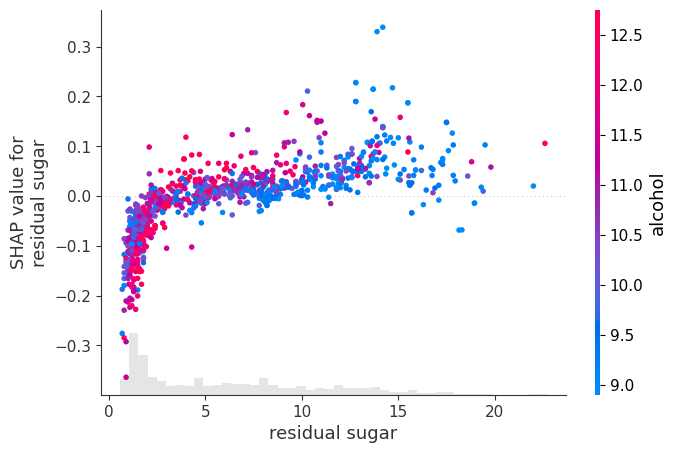

In [9]:
shap.plots.scatter( shap_values[:,"residual sugar"], color=shap_values )

# Analyzing correlated features

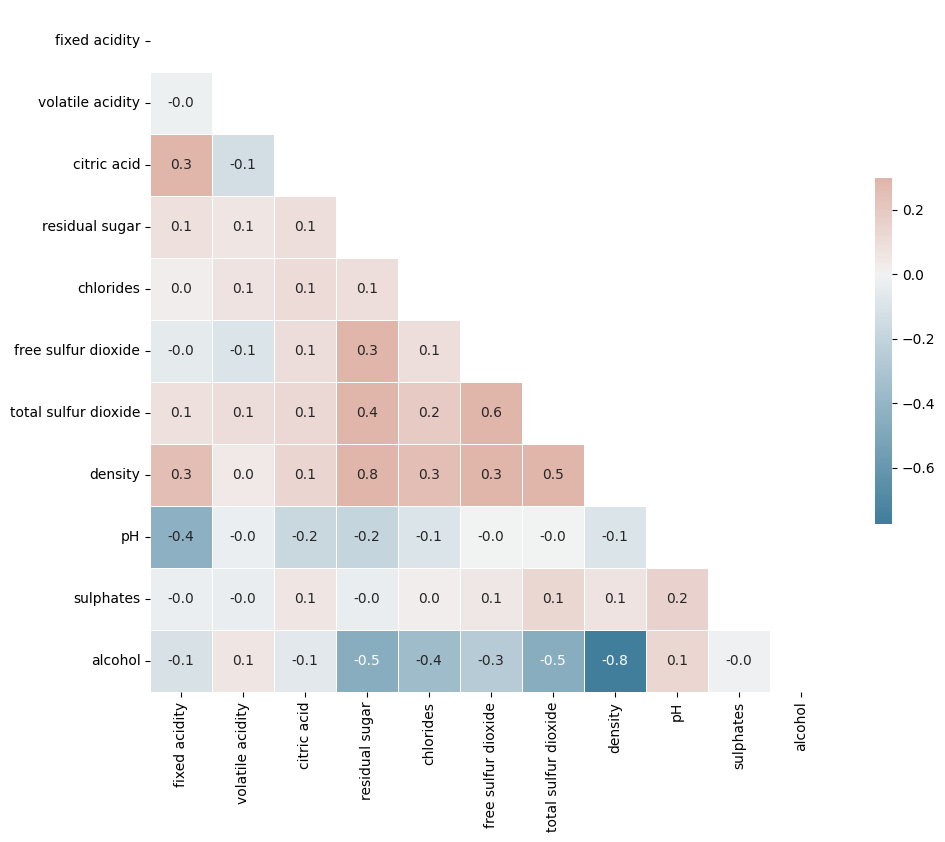

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# Compute the correlation matrix 
corr = X_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool)) 
# Set up the matplotlib figure 
f, ax = plt.subplots(figsize=(11, 9)) 
# Generate a diverging colormap 
cmap = sns.diverging_palette(230, 20, as_cmap=True) 
# Draw the heatmap with the mask and correct aspect ratio 
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".1f")
plt.show()

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


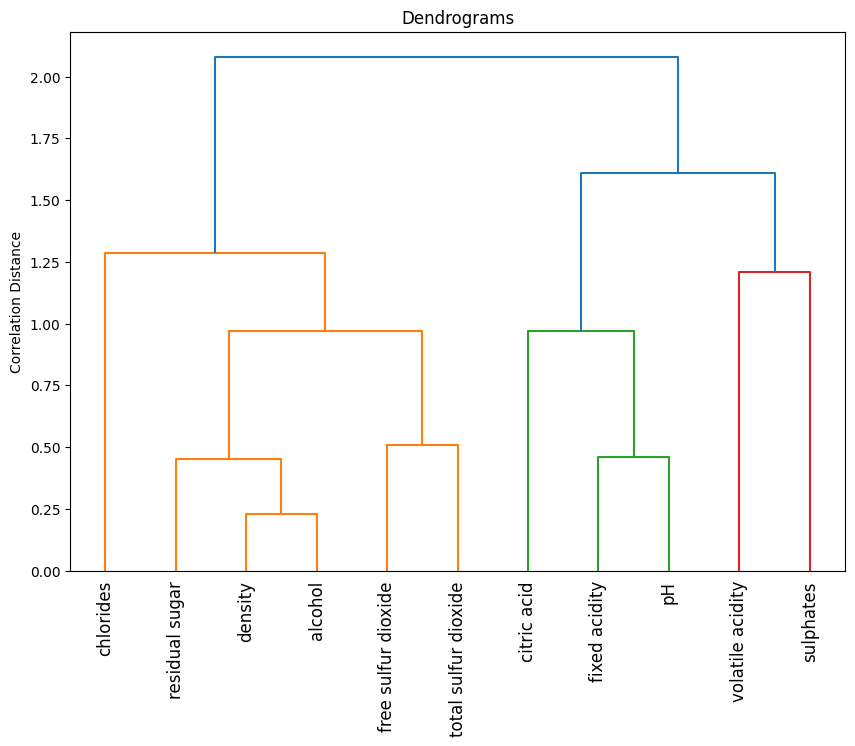

In [11]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
correlation_matrix = X_train.corr()
correlation_matrix = np.corrcoef(correlation_matrix)
correlation_matrix = np.abs(correlation_matrix)
dist_matrix = 1 - correlation_matrix 

import scipy.cluster.hierarchy as sch
clustering = sch.linkage(dist_matrix, method="complete") 
#clustering = shap.utils.hclust(X_train, metric='correlation')
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = hierarchy.dendrogram(clustering, labels=X_train.columns) 
# Rotate labels for better readability 
plt.xticks(rotation=90) 
# Increase label size for better visibility 
plt.tick_params(axis='x', which='major', labelsize=12)
plt.ylabel('Correlation Distance')
plt.show()

In [12]:
# masker = shap.maskers.Partition(X_train, clustering=clustering)
# explainer2 = shap.PartitionExplainer(model.predict, masker)
# shap_values2 = explainer2(X_test)

In [13]:
# fig = plt.figure(figsize=(6,12))
# ax0 = fig.add_subplot(211)
# shap.plots.bar(shap_values, max_display=11, show=False)
# ax1 = fig.add_subplot(212)
# shap.plots.bar( shap_values2, max_display=11, show=False, clustering_cutoff=0.6 )
# plt.tight_layout()
# plt.show()

In [14]:
# shap.plots.bar(shap_values2[0], clustering_cutoff=0.6)

# Understanding models for data subsets

In [15]:
# create the data subsets
ind_test = np.where(X_test['alcohol'].values > 12)
ind_train = np.where(X_train['alcohol'].values > 12)
X_train_sub = X_train.iloc[ind_train]
X_test_sub = X_test.iloc[ind_test] 
# SHAP where background data is based on subset 
explainer_sub = shap.Explainer(model, X_train_sub) 
shap_values_sub = explainer_sub(X_test_sub) 
# SHAP where background data includes all wines 
shap_values_sub_all = shap_values[ind_test]

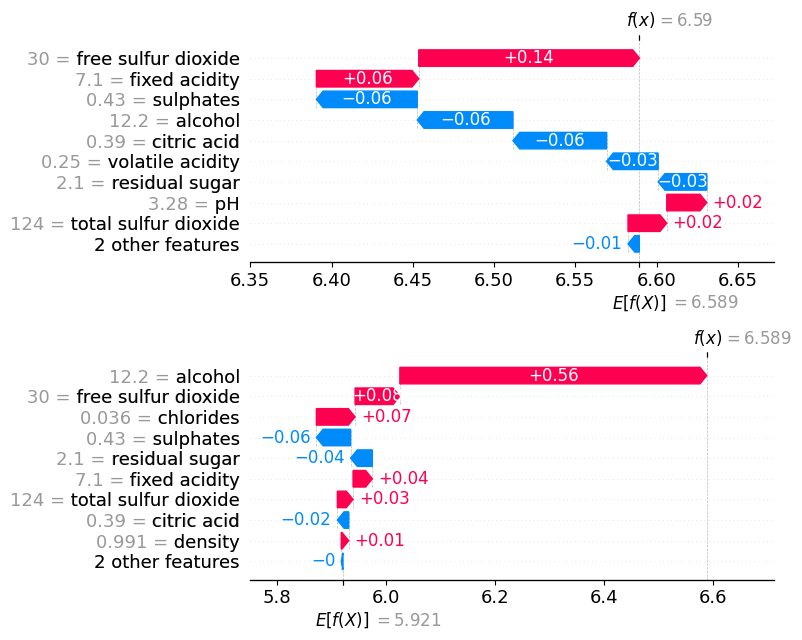

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211) 
shap.plots.waterfall(shap_values_sub[1], show=False) 
ax1 = fig.add_subplot(212) 
shap.plots.waterfall(shap_values_sub_all[1], show=False) 
plt.tight_layout() 
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


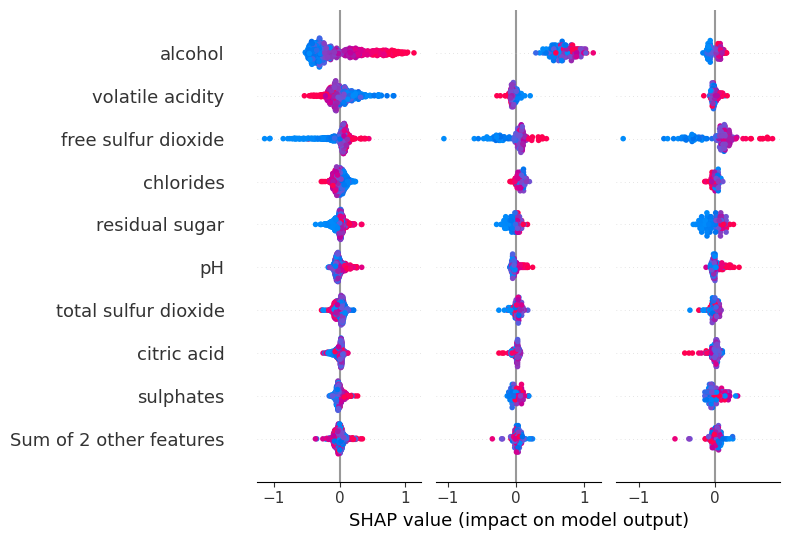

In [17]:
# sort based on SHAP importance for all data and all wines 
ordered = np.argsort(abs(shap_values.values).mean(axis=0))[::-1] 
plt.subplot(131) 
shap.plots.beeswarm( shap_values, show=False, color_bar=False, order=ordered ) 
plt.xlabel("") 
plt.subplot(132) 
shap.plots.beeswarm( shap_values_sub_all, show=False, color_bar=False, order=ordered )
plt.gca().set_yticklabels([]) # Remove y-axis labels 
plt.ylabel("") 
plt.subplot(133) 
shap.plots.beeswarm( shap_values_sub, show=False, color_bar=False, order=ordered ) 
plt.gca().set_yticklabels([]) # Remove y-axis labels 
plt.ylabel("") 
plt.xlabel("") 
plt.tight_layout() 
plt.show()